In [1]:
import pickle 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm 

data = pd.read_pickle('MiceCatV2/test1_sdss_g_abs_mag/fitting_parameters_completeness.pkl')
chunksize = int(10**6)
df = pd.read_csv('../../../../../LVK/load_catalog/small_cat_10.csv', chunksize=chunksize)
catalog = pd.DataFrame()
for chunk in tqdm(df):
    catalog = pd.concat([catalog, chunk])
    
catalog = catalog[['z_cgal','ra_gal','dec_gal','sdss_g_abs_mag', 'sdss_g_true']]
catalog = catalog.dropna()
catalog = catalog[catalog['z_cgal']>0]

50it [01:52,  2.24s/it]


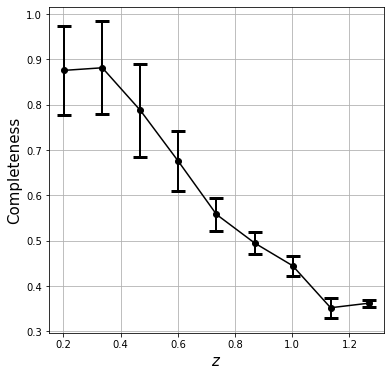

In [2]:
plt.figure(figsize =(6,6))
plt.errorbar(data['zbin_val'], data['completeness'], yerr = data['completeness_err'], color = 'black', elinewidth=2, capsize=7, capthick = 3, marker='o')
plt.ylabel('Completeness', fontsize = 15)
plt.xlabel(r'$z$', fontsize = 15)
plt.grid(True)
plt.show()

In [3]:
def fit_func(x, a,b,c,d):
    return a*x**(3)+b*x**(2)+c*x**(1)+d*x**(0)
xdata = data['zbin_val'] ; ydata = data['completeness'] ; d_y = data['completeness_err']
fit,cov=curve_fit(fit_func,xdata,ydata,sigma=d_y,absolute_sigma=True)

chisqr = sum((np.array(ydata)-fit_func(np.array(xdata),*fit))**2/np.array(d_y)**2)
dof = len(ydata) - 2
chisqr_red = chisqr/dof
print(f'Reduced chi^2 = {chisqr_red}')
print(f'Covariance Matrix: {cov}')

Reduced chi^2 = 0.3921429531584196
Covariance Matrix: [[ 0.21805635 -0.54554198  0.40907013 -0.08546358]
 [-0.54554198  1.37982678 -1.05234515  0.22665993]
 [ 0.40907013 -1.05234515  0.82451889 -0.18659477]
 [-0.08546358  0.22665993 -0.18659477  0.04625709]]


In [4]:
fit

array([ 0.65296099, -1.27361989,  0.12720602,  0.916746  ])

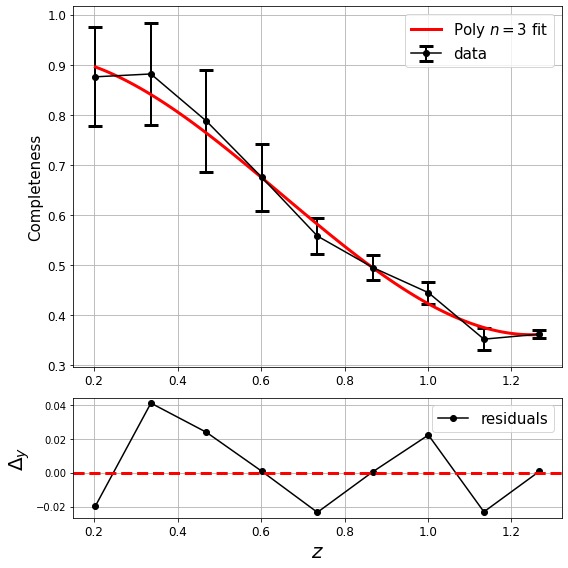

In [5]:
z_array = np.linspace(data['zbin_val'][0], data['zbin_val'][-1], 100)

fig, ax = plt.subplots(2,1, figsize = (8,8), gridspec_kw={'height_ratios': [3,1]})
ax[0].errorbar(data['zbin_val'], data['completeness'], yerr = data['completeness_err'], color = 'black', elinewidth=2, capsize=7, capthick = 3, marker='o', label = 'data')
ax[0].plot(z_array, fit_func(z_array, *fit), linewidth = 3, color = 'red', label =r'Poly $n = 3$ fit')
ax[0].set_ylabel('Completeness', fontsize = 15)
ax[0].grid(True)
ax[0].legend(loc = 'upper right', fontsize = 15)
ax[0].xaxis.set_tick_params(labelsize=12)
ax[0].yaxis.set_tick_params(labelsize=12)
fig.tight_layout() 

residuals = data['completeness'] - fit_func(np.array(data['zbin_val']), *fit)

ax[1].plot(np.array(data['zbin_val']), residuals,'-ok', label = 'residuals')
ax[1].axhline(y = 0 , linewidth = 3 , color = 'r', linestyle = 'dashed')
ax[1].set_xlabel('$z$', fontsize = 20)
ax[1].set_ylabel('$\Delta_{{y}}$', fontsize = 20)
ax[1].grid(True)
ax[1].legend(loc = 'upper right', fontsize = 15)
ax[1].xaxis.set_tick_params(labelsize=12)
fig.tight_layout() 

In [6]:
#### Lets do a test 
import os 
os.chdir('../../')
import cosmology 
dict_cosmo = {'H0': 70, 'Omega_m': 0.3, 'cosmo_model':'FlatLambdaCDM', 'w0':-1}
cosmo_class = cosmology.Cosmology(dict_cosmo)

N = 10000000

##Sample redshifts from comoving volume 
z_array = np.linspace(0.07,1.4, 1000)
dz = np.diff(z_array)[0]
pz = cosmo_class.dVdz(z_array)

def get_samples(x_array, dx,  pdf_array, N_samples):
    cdf = np.cumsum(pdf_array*dx)
    cdf /= np.max(cdf)
    t = np.random.uniform(0,1,N)
    return np.interp(t, cdf, x_array)

z_samples = get_samples(z_array, dz, pz, N)
ra_samples, dec_samples = cosmo_class.draw_RA_Dec(N)

In [7]:
small_cat = catalog

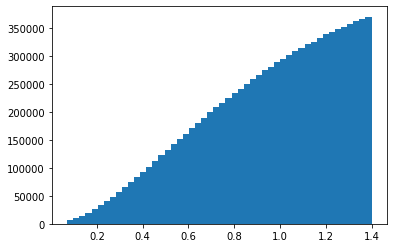

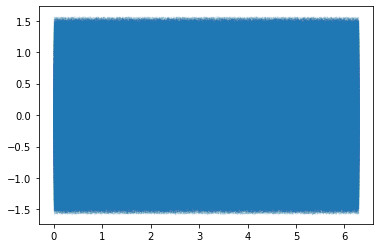

In [8]:
### plot redshift samples 
_ = plt.hist(z_samples, bins = 50)
plt.show()
_ = plt.scatter(x = ra_samples, y = dec_samples, alpha = 0.1, s = 0.1)
plt.show()

In [ ]:
small_cat.ra_gal

In [9]:
import healpy as hp
def make_sky_bin_map(ra,dec,NSIDE, type_angle = 'rad'):
    NSIDE = 64
    #Spherical Angles
    if type_angle == 'rad':
        phis = np.array(ra) 
        thetas = np.pi/2 - np.array(dec)
    elif type_angle == 'deg':
        phis = np.array(np.deg2rad(ra))
        thetas = np.pi/2 - np.array(np.deg2rad(dec))
    else: 
        raise ValueError("Type angle should be either [rad] or [deg]")
        
    positive_indicies = np.where(phis > 0)[0]
    phis = phis[positive_indicies]
    thetas = thetas[positive_indicies]
    #Turn angles into pixel indicies
    pixel_indices = hp.ang2pix(NSIDE, thetas, phis, nest = False)
    #Tot number of pixels 
    Npix = hp.nside2npix(NSIDE)
    #count indiceis in bins, (galaxy count per pixel)
    bc = np.bincount(pixel_indices, minlength=Npix)
    #initialise zeros mask
    mask = np.zeros(Npix, dtype = int) #Blank healpix map
    #N galaxies Threshold 
    Nth = 0
    inx = np.where(bc >= Nth) 
    mask[inx] = 1
    map_Glade = hp.mollview(bc*mask, title = 'NSIDE = {}, Event count per pixel'.format(NSIDE),rot = (0,0,0))
    hp.graticule(True)
    plt.show()
    return pixel_indices, Npix

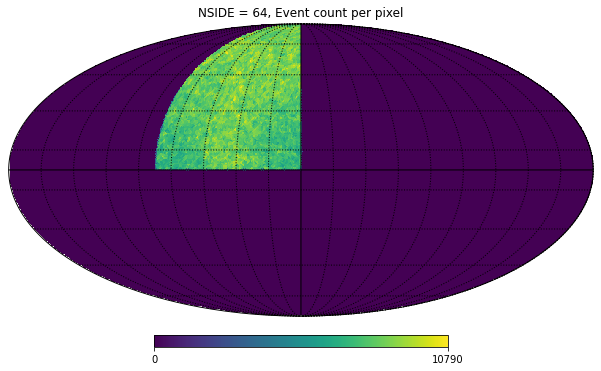

In [10]:
NSIDE = 64
pixels_mice, Npix = make_sky_bin_map(small_cat.ra_gal,small_cat.dec_gal,NSIDE, type_angle = 'deg')

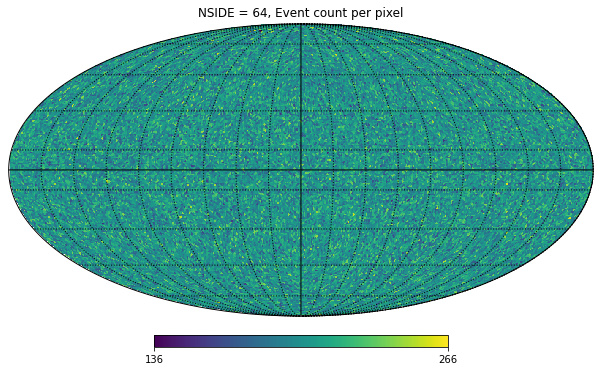

In [11]:
pixels_uniform, Npix = make_sky_bin_map(ra_samples,dec_samples,NSIDE, type_angle = 'rad')

In [14]:
indicies_cut = np.where(np.in1d(pixels_uniform, np.unique(pixels_mice)))[0]

# nocut_indicies = 
arr_pix = np.arange(Npix)
arr_pix_Mice = np.unique(pixels_mice)

def delete_elements_by_values(arr, values_to_delete):
    # Use list comprehension to create a new list without the specified values
    new_array = [element for element in arr if element not in values_to_delete]
    return new_array

arr_pix_nocut = delete_elements_by_values(arr_pix, arr_pix_Mice)
indicies_nocut = np.where(np.in1d(pixels_uniform, arr_pix_nocut))[0]

In [15]:
z_cut = z_samples[indicies_cut] ; ra_cut = ra_samples[indicies_cut] ; dec_cut = dec_samples[indicies_cut]
z_nocut = z_samples[indicies_nocut] ; ra_nocut = ra_samples[indicies_nocut] ; dec_nocut = dec_samples[indicies_nocut]

In [16]:
count, bins = np.histogram(z_cut, bins = 20)
bins = bins[1:]
complete_bins = fit_func(bins, *fit)
z_bins_cat_inx = np.digitize(small_cat.z_cgal, bins, right=False)
z_bins_out_inx = np.digitize(z_cut, bins, right=False)

In [17]:
samples_cat = [] 
samples_out_z = []
samples_out_ra = []
samples_out_dec = []


for i in tqdm(range(len(bins))):
    
    # if i == len(bins) - 1: 
    #     break
    count_in = int(count[i]*complete_bins[i]) #### PROBLEM !!
    count_out = int(count[i] - count_in)

    
    temp = catalog.z_cgal.loc[np.where(z_bins_cat_inx == i)[0]]
    ps = 1/(1+temp)
    ps /= np.sum(ps)
    
    temp_out = z_cut[np.where(z_bins_out_inx == i)[0]]
    temp_ra = ra_cut[np.where(z_bins_out_inx == i)[0]]
    temp_dec = dec_cut[np.where(z_bins_out_inx == i)[0]]
    
    
    ps_out = 1/(1+temp_out)
    ps_out /= np.sum(ps_out)
    
    if np.sum(ps) == 0:
        continue
    else:
        temp_df = temp.sample(n = int(count_in), weights = ps, replace = False)
        samples_cat.append(temp_df)
        
        inx_out = np.random.choice(np.arange(len(temp_out)), size=int(count_out), replace=False, p=ps_out)
        samples_out_z.append(temp_out[inx_out])
        samples_out_ra.append(temp_ra[inx_out])
        samples_out_dec.append(temp_dec[inx_out])
        
        

100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


In [18]:

inx_cat = pd.concat(samples_cat).index
galaxies_in = small_cat.loc[inx_cat]
galaxies_out_z = np.concatenate(samples_out_z)
galaxies_out_ra = np.concatenate(samples_out_ra)
galaxies_out_dec = np.concatenate(samples_out_dec)


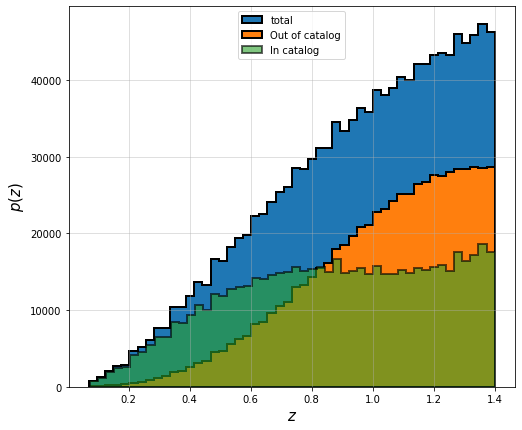

In [19]:
plt.figure(figsize = (8,7))
temp = np.hstack((galaxies_out_z, np.array(galaxies_in.z_cgal)))
plt.hist(temp, bins = 50, histtype = 'stepfilled', edgecolor='k', linewidth =2 , density = 0, label = 'total')
plt.hist(galaxies_out_z, bins = 50, histtype = 'stepfilled', edgecolor='k', linewidth =2 , density = 0, label = 'Out of catalog')
plt.hist(galaxies_in.z_cgal, bins = 50, histtype = 'stepfilled',edgecolor='k', linewidth =2 ,density = 0, alpha = 0.6,  label = 'In catalog')
plt.xlabel(r'$z$', fontsize = 15)
plt.ylabel(r'$p(z)$', fontsize = 15)
plt.legend(loc = 'upper center')
plt.grid(True, alpha = 0.5)
plt.show()



In [56]:
galaxies_out_z, np.array(galaxies_in)

(array([0.13193827, 0.10600562, 0.08602177, ..., 1.37559486, 1.35143571,
        1.3549934 ]),
 array([[  0.09548 ,  73.54757 ,  65.653048, -15.238   ,  22.17    ],
        [  0.11799 ,  61.192344,  22.21677 , -14.783   ,  23.332   ],
        [  0.12485 ,  39.378755,  39.133674, -14.04    ,  24.196   ],
        ...,
        [  1.36278 ,  46.566678,  21.303903, -19.265   ,  25.496   ],
        [  1.35353 ,  36.05477 ,  34.530934, -20.299   ,  25.836   ],
        [  1.34277 ,  46.372396,  83.798088, -19.965   ,  24.421   ]]))

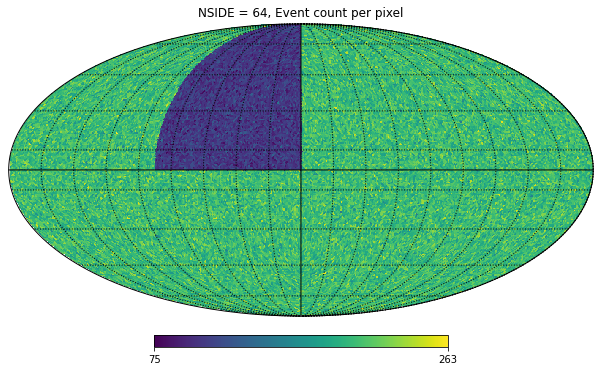

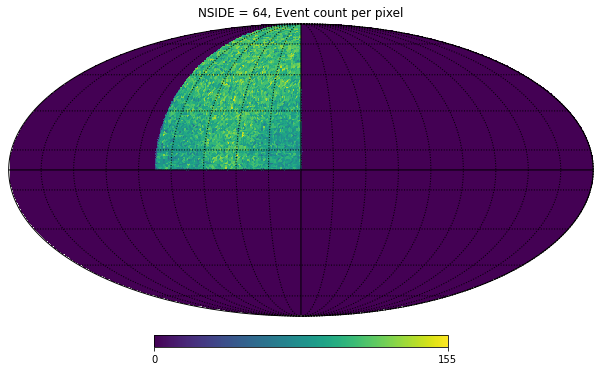

In [52]:
total_z_out = np.hstack((galaxies_out_z, z_nocut))
total_ra_out = np.hstack((galaxies_out_ra, ra_nocut))
total_dec_out = np.hstack((galaxies_out_dec, dec_nocut))

_, _ = make_sky_bin_map(total_ra_out,total_dec_out,NSIDE, type_angle = 'rad')
_, _ = make_sky_bin_map(galaxies_in.ra_gal,galaxies_in.dec_gal,NSIDE, type_angle = 'deg')
